In [155]:
import numpy as np
import pandas as pd
import torch
from torch import nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Nonlinear time-series generator (Dataset)

In [156]:
def generate_medium_difficulty_dataset(
    n_samples=5000,
    n_cont_features=10,
    n_cat_features=5,
    n_classes=3,
    lstm_sequence_length=None,  # optional
    random_state=42
):
    """
    Medium-difficulty synthetic dataset created by:
    - Random nonlinear MLP (hidden truth function)
    - Numeric interactions
    - Useful + useless noise
    - Balanced classes
    - Suitable reshaping for MLP, CNN, LSTM
    """

    torch.manual_seed(random_state)
    np.random.seed(random_state)

    # ============================================================
    # 1. Generate base features
    # ============================================================

    # Continuous base features
    X_cont = np.random.randn(n_samples, n_cont_features)

    # Add nonlinear transforms → adds medium complexity
    X_nonlin = np.column_stack([
        np.sin(X_cont[:, 0]),
        X_cont[:, 1] * X_cont[:, 2],
        np.tanh(X_cont[:, 3]),
        np.exp(-X_cont[:, 4]**2),
        (X_cont[:, 5] > 0).astype(float)
    ])

    # Noise features (useless)
    X_noise = np.random.randn(n_samples, 10)

    # Categorical
    # Slightly imbalanced, but not extreme
    X_cat = np.column_stack([
        np.random.choice([0,1,2,3,4], size=n_samples, p=[0.4,0.2,0.2,0.1,0.1]),
        np.random.choice([0,1,2,3,4], size=n_samples),
        np.random.choice([0,1,2,3,4], size=n_samples),
        np.random.choice([0,1,2,3,4], size=n_samples, p=[0.5,0.1,0.1,0.1,0.2]),
        np.random.choice([0,1,2,3,4], size=n_samples)
    ])


    # Combine everything
    X = np.hstack([X_cont, X_nonlin, X_noise, X_cat])
    total_features = X.shape[1]


    # ============================================================
    # 2. Hidden Random Neural Network to Generate Class Probabilities
    # ============================================================

    hidden_model = nn.Sequential(
        nn.Linear(total_features, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, n_classes)
    )

    for p in hidden_model.parameters():
        p.requires_grad = False

    with torch.no_grad():
        logits = hidden_model(torch.tensor(X, dtype=torch.float32))
        probs = torch.softmax(logits, dim=1).numpy()

    y = np.argmax(probs, axis=1)

    # Balance classes (important)
    # Re-sample to balance the dataset moderately
    final_idx = []
    for c in range(n_classes):
        cls_idx = np.where(y == c)[0]
        n_target = n_samples // n_classes
        if len(cls_idx) > n_target:
            cls_idx = np.random.choice(cls_idx, size=n_target, replace=False)
        else:
            cls_idx = np.random.choice(cls_idx, size=n_target, replace=True)
        final_idx.append(cls_idx)

    final_idx = np.concatenate(final_idx)
    np.random.shuffle(final_idx)

    X = X[final_idx]
    y = y[final_idx]


    # ============================================================
    # 3. Prepare MLP + CNN versions
    # ============================================================

    X_mlp = X.copy()
    X_cnn = X.reshape(X.shape[0], 1, -1)   # (batch, channel=1, features)


    # ============================================================
    # 4. Prepare LSTM Version
    # ============================================================

    if lstm_sequence_length is None:
        # choose a divisor of total_features that gives medium sequence length (not too small)
        divisors = [d for d in range(5, total_features+1) if total_features % d == 0]
        divisors.sort()
        lstm_sequence_length = divisors[len(divisors)//2]  # pick mid-level divisor

    if total_features % lstm_sequence_length != 0:
        raise ValueError("Chosen sequence length doesn't divide features")

    features_per_step = total_features // lstm_sequence_length
    X_lstm = X.reshape(X.shape[0], lstm_sequence_length, features_per_step)

    return X_mlp, X_cnn, X_lstm, y


* MLP --> receives the raw feature matrix X
* CNN --> Receives the same 15 features, but arranged as a single channel: This is just a reshape, no new data is created.
* LSTM --> Receives the same 15 features, but split into time steps: This also contains the same numbers, merely reorganized so the LSTM can process it.

In [157]:
X_mlp, X_cnn, X_lstm, y = generate_medium_difficulty_dataset()

In [158]:
df = pd.DataFrame(X_mlp, columns=[f"f{i}" for i in range(X_mlp.shape[1])])

# Convert categorical columns back to int
for c in [f"f{i}" for i in range(25, 30)]:
    df[c] = df[c].astype(int)

In [159]:
num_cols = [f"f{i}" for i in range(25)]
cat_cols = [f"f{i}" for i in range(25, 30)]

print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)
print("df columns:", df.columns.tolist())

Numeric cols: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24']
Categorical cols: ['f25', 'f26', 'f27', 'f28', 'f29']
df columns: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29']


In [160]:
df[cat_cols] = df[cat_cols].astype("category")

In [161]:
print(df.dtypes)

f0      float64
f1      float64
f2      float64
f3      float64
f4      float64
f5      float64
f6      float64
f7      float64
f8      float64
f9      float64
f10     float64
f11     float64
f12     float64
f13     float64
f14     float64
f15     float64
f16     float64
f17     float64
f18     float64
f19     float64
f20     float64
f21     float64
f22     float64
f23     float64
f24     float64
f25    category
f26    category
f27    category
f28    category
f29    category
dtype: object


In [162]:
preprocess_S1 = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),

        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), cat_cols)
    ],
    remainder='drop'
)

preprocess_S2 = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("impute", KNNImputer(n_neighbors=5)),
            ("scaler", MinMaxScaler())
        ]), num_cols),

        ("cat", Pipeline([
            ("target", TargetEncoder())
        ]), cat_cols)
    ],
    remainder='drop'
)

identity = FunctionTransformer(lambda x: x)

preprocess_S3 = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("impute", IterativeImputer(max_iter=3)),
            ("scaler", RobustScaler())
        ]), num_cols),

        ("cat", Pipeline([
            ("identity", identity)
        ]), cat_cols)
    ],
    remainder='drop'
)


In [163]:
for name, preproc in [("S1", preprocess_S1), ("S2", preprocess_S2), ("S3", preprocess_S3)]:
    Xp = preproc.fit_transform(df, y)
    print(name, Xp.shape)

S1 (4998, 50)
S2 (4998, 30)
S3 (4998, 30)


In [164]:
print(X_mlp.shape)
print(X_cnn.shape)
print(X_lstm.shape)
print(y.shape)

(4998, 30)
(4998, 1, 30)
(4998, 10, 3)
(4998,)


In [165]:
df = pd.DataFrame(X_mlp, columns=[f"f{i}" for i in range(X_mlp.shape[1])])

num_cols = [f"f{i}" for i in range(25)]
cat_cols = [f"f{i}" for i in range(25, 30)]

df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29
0,-1.710808,0.308763,2.355629,-0.042540,0.180019,-0.310260,0.667262,0.362209,-0.676047,-0.114353,...,0.959218,-0.110982,-0.357152,1.688971,0.092737,3.0,4.0,1.0,3.0,0.0
1,-1.290487,1.542297,1.159330,-0.103989,-0.488313,-0.609441,-2.585653,0.353820,0.780324,0.137902,...,-0.059107,-2.016945,0.774187,0.088960,-1.605960,0.0,0.0,4.0,0.0,0.0
2,-0.287306,-0.189568,-0.060016,0.385205,-0.000263,-0.133395,1.308918,0.565596,-0.958804,0.740674,...,-0.557216,1.644009,1.646138,0.225626,-0.827511,1.0,3.0,0.0,1.0,4.0
3,-1.290487,1.542297,1.159330,-0.103989,-0.488313,-0.609441,-2.585653,0.353820,0.780324,0.137902,...,-0.059107,-2.016945,0.774187,0.088960,-1.605960,0.0,0.0,4.0,0.0,0.0
4,-1.290487,1.542297,1.159330,-0.103989,-0.488313,-0.609441,-2.585653,0.353820,0.780324,0.137902,...,-0.059107,-2.016945,0.774187,0.088960,-1.605960,0.0,0.0,4.0,0.0,0.0


In [166]:
print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)
print("df columns:", df.columns.tolist())

Numeric cols: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24']
Categorical cols: ['f25', 'f26', 'f27', 'f28', 'f29']
df columns: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29']


In [167]:
CAPACITY = {
    "Low":    {"hidden": 32,  "dropout": 0.2, "lr": 1e-3},
    "Medium": {"hidden": 64,  "dropout": 0.2, "lr": 1e-3},
    "High":   {"hidden": 128, "dropout": 0.1, "lr": 5e-4}
}

### MLP Experiment (S1, S2 and S3 comparison)

* S1 = MedianImpute → StandardScaler → OneHotEncoder
* S2 = KNNImputer(k=5) → MinMaxScaler → TargetEncode
* S3 = MICE(3 iters) → RobustScaler → Embedding Layer (this will be ignored for MLP)


In [168]:
from sklearn.metrics import accuracy_score, f1_score


def split_for_strategy(X, strategy, num_numeric=25):
    """
    S1 & S2 → fully numeric (no categorical input)
    S3 → numeric + raw categorical integer IDs
    """
    if strategy in ["S1", "S2"]:
        return torch.tensor(X, dtype=torch.float32), None
    
    # S3 → must split numeric vs categorical
    X_num = torch.tensor(X[:, :num_numeric], dtype=torch.float32)
    X_cat = torch.tensor(X[:, num_numeric:].astype(int), dtype=torch.long)
    return X_num, X_cat

In [169]:
class MLP_with_Embeddings(nn.Module):
    def __init__(self, 
                 hidden_dim=64, 
                 dropout=0.2,
                 num_numeric=25, 
                 cat_cardinalities=[5]*5, 
                 embed_dim=8, 
                 num_classes=3):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.dropout_p = dropout

        # ----- Embeddings (S3 only) -----
        self.embeddings = nn.ModuleList([
            nn.Embedding(card, embed_dim)
            for card in cat_cardinalities
        ])

        # ----- Lazy first layer (depends on S1/S2 vs S3 input size) -----
        self.fc1 = None

        # ----- Middle + output layers -----
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_classes)

    def initialize_first_layer(self, input_dim):
        """Lazy init once we know the dimensionality."""
        if self.fc1 is None:
            self.fc1 = nn.Linear(input_dim, self.hidden_dim)

    def forward(self, x_num, x_cat=None):

        # ----- Case 1: S1/S2 -----
        if x_cat is None:
            mlp_input = x_num

        # ----- Case 2: S3 → numeric + embeddings -----
        else:
            embedded = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
            embedded = torch.cat(embedded, dim=1)
            mlp_input = torch.cat([x_num, embedded], dim=1)

        # Lazy init fc1 now that input size is known
        if self.fc1 is None:
            self.initialize_first_layer(mlp_input.shape[1])

        # ----- Feedforward MLP -----
        x = torch.relu(self.fc1(mlp_input))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        out = self.fc3(x)

        return out


In [170]:
def train(model, optimizer, criterion, X_num, X_cat, y, epochs=20):
    model.train()
    for _ in range(epochs):
        optimizer.zero_grad()
        preds = model(X_num, X_cat)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()


def evaluate(model, X_num, X_cat, y):
    model.eval()
    with torch.no_grad():
        preds = model(X_num, X_cat)
        preds = preds.argmax(dim=1)

    acc = accuracy_score(y, preds)
    f1 = f1_score(y, preds, average="weighted")
    return acc, f1


In [171]:
results = []

preprocessors = {
    "S1": preprocess_S1,
    "S2": preprocess_S2,
    "S3": preprocess_S3
}

# Use MLP dataset
X_mlp, _, _, y = generate_medium_difficulty_dataset()

# Split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df, y, test_size=0.25, random_state=42
)

for strategy, preproc in preprocessors.items():
    print(f"\n🚀 Running MLP with {strategy}")

    # 1. Preprocess
    X_train_prep = preproc.fit_transform(X_train_raw, y_train)
    X_test_prep = preproc.transform(X_test_raw)

    # 2. Split numeric vs cats for S3
    X_train_num, X_train_cat = split_for_strategy(X_train_prep, strategy)
    X_test_num, X_test_cat = split_for_strategy(X_test_prep, strategy)

    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # 3. Build model
    model = MLP_with_Embeddings(
        num_numeric=25,
        cat_cardinalities=[5]*5,
        embed_dim=8,
        num_classes=3
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # 4. Train
    train(model, optimizer, criterion, X_train_num, X_train_cat, y_train_tensor)

    # 5. Eval
    acc, f1 = evaluate(model, X_test_num, X_test_cat, y_test_tensor)

    results.append({
        "Model": "MLP",
        "Preprocessing": strategy,
        "Accuracy": acc,
        "F1 Score": f1
    })

results_df = pd.DataFrame(results)
results_df



🚀 Running MLP with S1

🚀 Running MLP with S2

🚀 Running MLP with S3


,Model,Preprocessing,Accuracy,F1 Score
0,MLP,S1,0.7272,0.705511
1,MLP,S2,0.6088,0.573197
2,MLP,S3,0.7320,0.730453


### CNN Experiment (S1, S2 and S3 comparison)

In [172]:
class TabularCNN(nn.Module):
    def __init__(self, num_features, num_classes=3, hidden_dim=32, dropout=0.2):
        super().__init__()

        self.conv1 = nn.Conv1d(1, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim*2, kernel_size=3, padding=1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.pool = nn.AdaptiveAvgPool1d(1)

        self.fc = nn.Linear(hidden_dim*2, num_classes)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x).squeeze(-1)
        x = self.dropout(x)
        return self.fc(x)


In [173]:
def train_cnn(model, optimizer, criterion, X, y, epochs=20):
    model.train()
    for _ in range(epochs):
        optimizer.zero_grad()
        preds = model(X)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

def eval_cnn(model, X, y):
    model.eval()
    with torch.no_grad():
        preds = model(X)
        preds = preds.argmax(dim=1)
        acc = accuracy_score(y, preds)
        f1 = f1_score(y, preds, average="weighted")
    return acc, f1


In [174]:
df_train, df_test, y_train, y_test = train_test_split(
    df, y, test_size=0.25, random_state=42
)


In [175]:
# ----------------------------------------
# TRAIN/TEST SPLIT FOR CNN EXPERIMENT
# ----------------------------------------
df_train, df_test, y_train, y_test = train_test_split(
    df, y, test_size=0.25, random_state=42
)

results_cnn = []

for strategy, preproc in {
    "S1": preprocess_S1,
    "S2": preprocess_S2,
    "S3": preprocess_S3
}.items():

    print(f"\n🚀 Running CNN with {strategy}")

    # 1. Fit preprocessing on TRAIN only
    X_train_prep = preproc.fit_transform(df_train, y_train)
    X_test_prep  = preproc.transform(df_test)

    # 2. Convert to tensors & reshape for CNN: (batch, channels=1, features)
    X_train_tensor = torch.tensor(X_train_prep, dtype=torch.float32).reshape(
        -1, 1, X_train_prep.shape[1]
    )
    X_test_tensor = torch.tensor(X_test_prep, dtype=torch.float32).reshape(
        -1, 1, X_test_prep.shape[1]
    )

    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    y_test_tensor  = torch.tensor(y_test, dtype=torch.long)

    # 3. Build model
    model = TabularCNN(num_features=X_train_prep.shape[1], num_classes=3)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # 4. Train CNN
    train_cnn(model, optimizer, criterion, X_train_tensor, y_train_tensor)

    # 5. Evaluate
    acc, f1 = eval_cnn(model, X_test_tensor, y_test_tensor)

    # 6. Store results
    results_cnn.append({
        "Model": "CNN",
        "Preprocessing": strategy,
        "Accuracy": acc,
        "F1 Score": f1
    })

pd.DataFrame(results_cnn)



🚀 Running CNN with S1

🚀 Running CNN with S2

🚀 Running CNN with S3


,Model,Preprocessing,Accuracy,F1 Score
0,CNN,S1,0.3952,0.314655
1,CNN,S2,0.5408,0.557091
2,CNN,S3,0.3928,0.311492


### LSTM Experiment (S1, S2 and S3 comparison)

In [176]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, num_layers=1, dropout=0.2,
                 num_classes=3, cat_cardinalities=None, embed_dim=8):
        super().__init__()

        self.has_cat = cat_cardinalities is not None

        if self.has_cat:
            self.embeddings = nn.ModuleList(
                [nn.Embedding(card, embed_dim) for card in cat_cardinalities]
            )
            lstm_input_dim = input_dim + len(cat_cardinalities)*embed_dim
        else:
            lstm_input_dim = input_dim

        self.lstm = nn.LSTM(
            lstm_input_dim,
            hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x_seq, x_cat=None):

        if self.has_cat:
            embedded = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
            embedded = torch.cat(embedded, dim=1)
            embedded = embedded.unsqueeze(1).repeat(1, x_seq.shape[1], 1)
            x_seq = torch.cat([x_seq, embedded], dim=2)

        _, (h_last, _) = self.lstm(x_seq)
        h_last = self.dropout(h_last[-1])
        return self.fc(h_last)


In [177]:
def train_lstm(model, optimizer, criterion, X_num, X_cat, y, epochs=15):
    model.train()
    for _ in range(epochs):
        optimizer.zero_grad()
        preds = model(X_num, X_cat)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

def eval_lstm(model, X_num, X_cat, y):
    model.eval()
    with torch.no_grad():
        preds = model(X_num, X_cat)
        preds = preds.argmax(1)
        acc = accuracy_score(y, preds)
        f1 = f1_score(y, preds, average="weighted")
    return acc, f1


In [178]:
import numpy as np

SEQ_LEN = 5       # ⭐ FIXED: must divide NUM_COLS
NUM_COLS = 25     # 25 numeric features

results_lstm = []

preprocessors = {
    "S1": preprocess_S1,
    "S2": preprocess_S2,
    "S3": preprocess_S3
}

# Splits made earlier (same as for MLP + CNN)
df_train, df_test, y_train, y_test = train_test_split(df, y, test_size=0.25, random_state=42)

for strategy, preproc in preprocessors.items():

    print(f"\n🚀 Running LSTM with {strategy}")

    # 1. Preprocess
    X_train_prep = preproc.fit_transform(df_train, y_train)
    X_test_prep = preproc.transform(df_test)

    # ---- NUMERIC BLOCK ----
    X_train_num = X_train_prep[:, :NUM_COLS]
    X_test_num  = X_test_prep[:, :NUM_COLS]

    # reshape into sequences
    features_per_step = NUM_COLS // SEQ_LEN

    X_train_num = torch.tensor(
        X_train_num.reshape(-1, SEQ_LEN, features_per_step),
        dtype=torch.float32
    )

    X_test_num = torch.tensor(
        X_test_num.reshape(-1, SEQ_LEN, features_per_step),
        dtype=torch.float32
    )

    # ---- CATEGORICAL BLOCK (only for S3) ----
    if strategy == "S3":
        X_train_cat_raw = X_train_prep[:, NUM_COLS:].astype(int)
        X_test_cat_raw  = X_test_prep[:, NUM_COLS:].astype(int)

        X_train_cat = torch.tensor(X_train_cat_raw, dtype=torch.long)
        X_test_cat  = torch.tensor(X_test_cat_raw, dtype=torch.long)

        cat_cardinalities = [5,5,5,5,5]
    else:
        X_train_cat = None
        X_test_cat = None
        cat_cardinalities = None

    # ---- Labels ----
    y_train_t = torch.tensor(y_train, dtype=torch.long)
    y_test_t  = torch.tensor(y_test, dtype=torch.long)

    # ---- Model ----
    model = LSTMClassifier(
        input_dim=features_per_step,
        hidden_dim=32,
        num_layers=1,
        num_classes=3,
        cat_cardinalities=cat_cardinalities
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # ---- Train ----
    train_lstm(model, optimizer, criterion, X_train_num, X_train_cat, y_train_t)

    # ---- Evaluate ----
    acc, f1 = eval_lstm(model, X_test_num, X_test_cat, y_test_t)

    results_lstm.append({
        "Model": "LSTM",
        "Preprocessing": strategy,
        "Accuracy": acc,
        "F1 Score": f1
    })

results_lstm = pd.DataFrame(results_lstm)
results_lstm



🚀 Running LSTM with S1

🚀 Running LSTM with S2

🚀 Running LSTM with S3


,Model,Preprocessing,Accuracy,F1 Score
0,LSTM,S1,0.4344,0.346086
1,LSTM,S2,0.4024,0.306571
2,LSTM,S3,0.5952,0.533032


In [181]:
############################################################
# FULL FACTORIAL EXPERIMENT — 3x3x3 with 2 REPLICATES
############################################################

results_full = []

MODELS = ["MLP", "CNN", "LSTM"]
CAPACITIES = ["Low", "Medium", "High"]
PREPROCS = {"S1": preprocess_S1, "S2": preprocess_S2, "S3": preprocess_S3}

NUM_COLS = 25
SEQ_LEN = 5
features_per_step = NUM_COLS // SEQ_LEN  

N_REP = 2   # ⭐ TWO REPLICATES

for rep in range(1, N_REP + 1):

    print(f"\n========================")
    print(f"🔥 REPLICATE {rep}")
    print("========================\n")

    # Re-split every replicate → random variation
    df_train, df_test, y_train, y_test = train_test_split(
        df, y, test_size=0.25, random_state=42 + rep
    )

    y_train_t = torch.tensor(y_train, dtype=torch.long)
    y_test_t  = torch.tensor(y_test, dtype=torch.long)

    for model_name in MODELS:
        for cap in CAPACITIES:
            for strat, preproc in PREPROCS.items():

                print(f"\n🚀 Running {model_name} | {cap} | {strat} | Rep {rep}")

                cfg = CAPACITY[cap]

                # ---------------------------------------
                # 1. Preprocess
                # ---------------------------------------
                X_train_prep = preproc.fit_transform(df_train, y_train)
                X_test_prep  = preproc.transform(df_test)

                # ---------------------------------------
                # 2. Prepare inputs
                # ---------------------------------------
                if strat in ["S1", "S2"]:
                    X_train_num = torch.tensor(X_train_prep, dtype=torch.float32)
                    X_test_num  = torch.tensor(X_test_prep, dtype=torch.float32)
                    X_train_cat = X_test_cat = None
                else:
                    X_train_num = torch.tensor(X_train_prep[:, :NUM_COLS], dtype=torch.float32)
                    X_test_num  = torch.tensor(X_test_prep[:, :NUM_COLS], dtype=torch.float32)

                    X_train_cat = torch.tensor(
                        X_train_prep[:, NUM_COLS:].astype(int),
                        dtype=torch.long
                    )
                    X_test_cat  = torch.tensor(
                        X_test_prep[:, NUM_COLS:].astype(int),
                        dtype=torch.long
                    )

                # LSTM reshaping
                X_train_seq = torch.tensor(
                    X_train_prep[:, :NUM_COLS].reshape(-1, SEQ_LEN, features_per_step),
                    dtype=torch.float32
                )
                X_test_seq = torch.tensor(
                    X_test_prep[:, :NUM_COLS].reshape(-1, SEQ_LEN, features_per_step),
                    dtype=torch.float32
                )

                # ---------------------------------------
                # 3. Build and train model
                # ---------------------------------------
                if model_name == "MLP":

                    model = MLP_with_Embeddings(
                        hidden_dim=cfg["hidden"],
                        dropout=cfg["dropout"],
                        num_classes=3
                    )

                    optimizer = torch.optim.Adam(model.parameters(), lr=cfg["lr"])
                    criterion = nn.CrossEntropyLoss()

                    for _ in range(20):
                        optimizer.zero_grad()
                        preds = model(X_train_num, X_train_cat)
                        loss = criterion(preds, y_train_t)
                        loss.backward()
                        optimizer.step()

                    with torch.no_grad():
                        preds = model(X_test_num, X_test_cat).argmax(1)

                elif model_name == "CNN":

                    X_train_cnn = torch.tensor(
                        X_train_prep.reshape(-1, 1, X_train_prep.shape[1]),
                        dtype=torch.float32)
                    X_test_cnn = torch.tensor(
                        X_test_prep.reshape(-1, 1, X_test_prep.shape[1]),
                        dtype=torch.float32)

                    model = TabularCNN(num_features=X_train_prep.shape[1], num_classes=3)
                    optimizer = torch.optim.Adam(model.parameters(), lr=cfg["lr"])
                    criterion = nn.CrossEntropyLoss()

                    for _ in range(20):
                        optimizer.zero_grad()
                        preds = model(X_train_cnn)
                        loss = criterion(preds, y_train_t)
                        loss.backward()
                        optimizer.step()

                    with torch.no_grad():
                        preds = model(X_test_cnn).argmax(1)

                else:  # LSTM

                    model = LSTMClassifier(
                        input_dim=features_per_step,
                        hidden_dim=cfg["hidden"],
                        num_layers=1,
                        num_classes=3,
                        cat_cardinalities=[5]*5 if strat=="S3" else None
                    )

                    optimizer = torch.optim.Adam(model.parameters(), lr=cfg["lr"])
                    criterion = nn.CrossEntropyLoss()

                    for _ in range(15):
                        optimizer.zero_grad()
                        preds = model(
                            X_train_seq,
                            X_train_cat if strat == "S3" else None
                        )
                        loss = criterion(preds, y_train_t)
                        loss.backward()
                        optimizer.step()

                    with torch.no_grad():
                        preds = model(
                            X_test_seq,
                            X_test_cat if strat == "S3" else None
                        ).argmax(1)

                # ---------------------------------------
                # 4. Record results
                # ---------------------------------------
                acc = accuracy_score(y_test, preds)
                f1 = f1_score(y_test, preds, average="weighted")

                results_full.append({
                    "Replicate": rep,
                    "Model": model_name,
                    "Capacity": cap,
                    "Preprocessing": strat,
                    "Accuracy": acc,
                    "F1 Score": f1
                })

results_full = pd.DataFrame(results_full)
results_full



🔥 REPLICATE 1


🚀 Running MLP | Low | S1 | Rep 1

🚀 Running MLP | Low | S2 | Rep 1

🚀 Running MLP | Low | S3 | Rep 1

🚀 Running MLP | Medium | S1 | Rep 1

🚀 Running MLP | Medium | S2 | Rep 1

🚀 Running MLP | Medium | S3 | Rep 1

🚀 Running MLP | High | S1 | Rep 1

🚀 Running MLP | High | S2 | Rep 1

🚀 Running MLP | High | S3 | Rep 1

🚀 Running CNN | Low | S1 | Rep 1

🚀 Running CNN | Low | S2 | Rep 1

🚀 Running CNN | Low | S3 | Rep 1

🚀 Running CNN | Medium | S1 | Rep 1

🚀 Running CNN | Medium | S2 | Rep 1

🚀 Running CNN | Medium | S3 | Rep 1

🚀 Running CNN | High | S1 | Rep 1

🚀 Running CNN | High | S2 | Rep 1

🚀 Running CNN | High | S3 | Rep 1

🚀 Running LSTM | Low | S1 | Rep 1

🚀 Running LSTM | Low | S2 | Rep 1

🚀 Running LSTM | Low | S3 | Rep 1

🚀 Running LSTM | Medium | S1 | Rep 1

🚀 Running LSTM | Medium | S2 | Rep 1

🚀 Running LSTM | Medium | S3 | Rep 1

🚀 Running LSTM | High | S1 | Rep 1

🚀 Running LSTM | High | S2 | Rep 1

🚀 Running LSTM | High | S3 | Rep 1

🔥 REPLICATE 2


🚀 Ru

,Replicate,Model,Capacity,Preprocessing,Accuracy,F1 Score
0,1,MLP,Low,S1,0.4696,0.404442
1,1,MLP,Low,S2,0.4816,0.412573
2,1,MLP,Low,S3,0.5352,0.504021
3,1,MLP,Medium,S1,0.7264,0.720977
4,1,MLP,Medium,S2,0.5752,0.557155
5,1,MLP,Medium,S3,0.6376,0.641227
6,1,MLP,High,S1,0.7664,0.765639
7,1,MLP,High,S2,0.5936,0.543740
8,1,MLP,High,S3,0.6864,0.665401
9,1,CNN,Low,S1,0.4584,0.451206


In [182]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

dfA = results_full.copy()
dfA["Model"] = dfA["Model"].astype("category")
dfA["Capacity"] = dfA["Capacity"].astype("category")
dfA["Preprocessing"] = dfA["Preprocessing"].astype("category")

# Full 3-way factorial ANOVA
anova_acc = smf.ols(
    "Accuracy ~ C(Model) * C(Capacity) * C(Preprocessing)",
    data=dfA
).fit()

anova_table_acc = sm.stats.anova_lm(anova_acc, typ=2)
print("\n📊 ANOVA Results for Accuracy (Full Factorial)\n")
display(anova_table_acc)

# Same for F1
anova_f1 = smf.ols(
    "Q('F1 Score') ~ C(Model) * C(Capacity) * C(Preprocessing)",
    data=dfA
).fit()

anova_table_f1 = sm.stats.anova_lm(anova_f1, typ=2)
print("\n📊 ANOVA Results for F1 Score (Full Factorial)\n")
display(anova_table_f1)



📊 ANOVA Results for Accuracy (Full Factorial)



,sum_sq,df,F,PR(>F)
C(Model),0.248283,2.0,84.391574,2.423506e-12
C(Capacity),0.066239,2.0,22.514716,1.766143e-06
C(Preprocessing),0.146289,2.0,49.723672,8.863999e-10
C(Model):C(Capacity),0.135379,4.0,23.007763,2.292655e-08
C(Model):C(Preprocessing),0.082507,4.0,14.022060,2.597234e-06
C(Capacity):C(Preprocessing),0.010562,4.0,1.794939,1.589955e-01
C(Model):C(Capacity):C(Preprocessing),0.023637,8.0,2.008524,8.400620e-02
Residual,0.039717,27.0,NaN,NaN



📊 ANOVA Results for F1 Score (Full Factorial)



,sum_sq,df,F,PR(>F)
C(Model),0.265604,2.0,29.597583,1.564557e-07
C(Capacity),0.070472,2.0,7.853023,2.050239e-03
C(Preprocessing),0.187839,2.0,20.931909,3.239896e-06
C(Model):C(Capacity),0.193286,4.0,10.769448,2.379548e-05
C(Model):C(Preprocessing),0.121869,4.0,6.790265,6.442573e-04
C(Capacity):C(Preprocessing),0.017461,4.0,0.972909,4.385641e-01
C(Model):C(Capacity):C(Preprocessing),0.054556,8.0,1.519866,1.967525e-01
Residual,0.121147,27.0,NaN,NaN


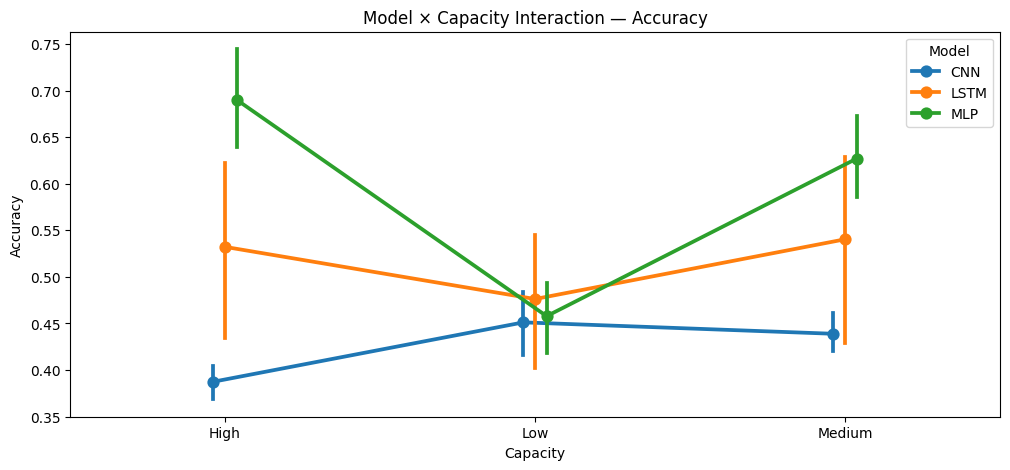

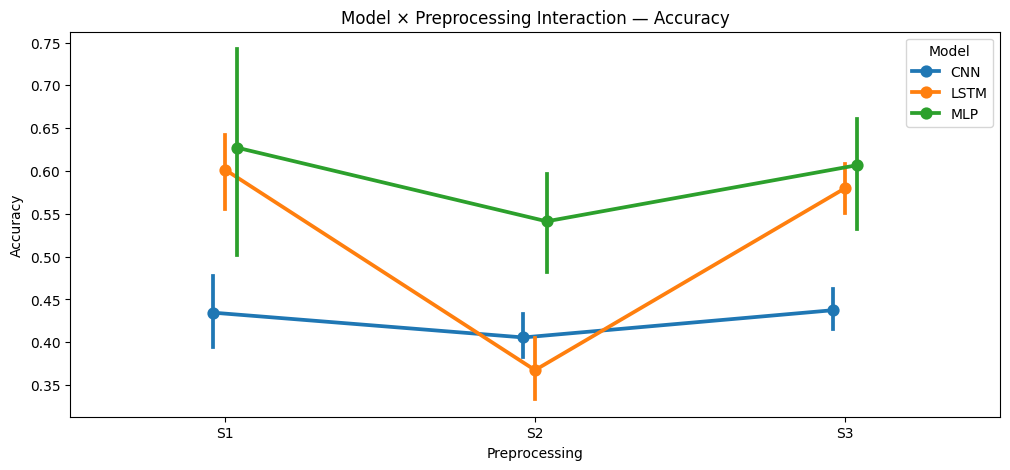

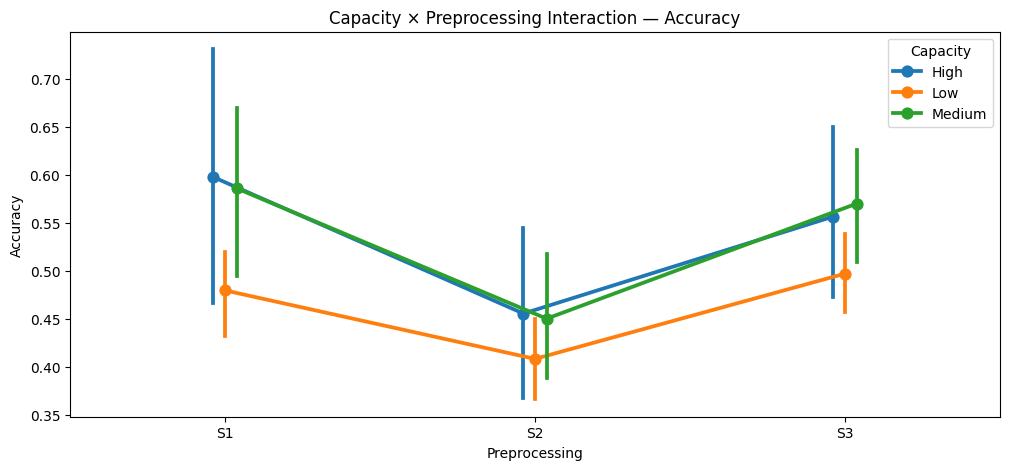

In [183]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
sns.pointplot(
    data=dfA,
    x="Capacity",
    y="Accuracy",
    hue="Model",
    dodge=True
)
plt.title("Model × Capacity Interaction — Accuracy")
plt.show()

plt.figure(figsize=(12,5))
sns.pointplot(
    data=dfA,
    x="Preprocessing",
    y="Accuracy",
    hue="Model",
    dodge=True
)
plt.title("Model × Preprocessing Interaction — Accuracy")
plt.show()

plt.figure(figsize=(12,5))
sns.pointplot(
    data=dfA,
    x="Preprocessing",
    y="Accuracy",
    hue="Capacity",
    dodge=True
)
plt.title("Capacity × Preprocessing Interaction — Accuracy")
plt.show()
